# Driver drowsiness detection

#### Team members:
Chunlin Yang  — yang291@iu.edu  
Yuhui Hong — yuhhong@iu.edu  
Vijayanand Kandasamy — Vkandasa@iu.edu  

## Abstract
Studies show that more than 100,000 car crashes are caused by drowsy driving each year. Thus, if there is an intelligent system inside the car that can detect the moment when the drivers doze off and start the warning in time, it may make numerous drivers breathe a sigh of relief. With the development of deep learning technology, the application of deep learning in image recognition has reached a high accuracy rate. Therefore, it becomes possible to apply deep learning to recognize drowsy driving. In this project, we will analyze a big load of photos of drivers behind a wheel and build a series of deep learning models to accurately detect drowsy driving.

## Data description
For our purpose of data visualization and detection of driver drowsiness, we will use PyTorch as a framework to build the models with the initial dataset from Kaggle (https://www.kaggle.com/code/adinishad/driver-drowsiness-using-keras), which contains 720 images per label to train and test the models. The labels include:  1) Closed - Eyes are closed more than 5 seconds; 2) Open - Eyes are opened; 3) Yawn - Driver's yawning; 4) No_yawn - Driver's not yawning.
Final result: Driver video on a player will be played along with a model process in each frame to display results like frequency of eyes closed/open, which will generate alerts.

## Goals
Our goals can be described as the following parts: 
1) Our basic task is to design a deep-learning model for image classification. Considering that the dataset is mini, we could try the light models for establishing the benchmark: plain fully connected neural networks, plain convolutional neural networks, the shallow ResNet, the series of MobileNets, the series of Capsule Neural Networks, etc. 
2) To apply drowsiness detection in the real world, we would like to detect the faces in the whole scene using YOLO-lite or Swin, then classify cropped faces. 
3) (optional) An application in Windows, Linux, IOS, or Android can be established based on the first two steps. 
Other thoughts: In real-world applications, videos are easy to be obtained at the same time as images. Compared to the images (single frame) video contains contextual information, which may help to detect the faces. The sequence-based models can extract the features in time dimensions, such as RNN (recurrent neural network), LSTM (long short-term memory network), and Transformers. Video object detection could be an additional plan for our project.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras import initializers
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

import os

In [2]:
# load the data from google drive

from google.colab import drive, files
drive.mount('/content/drive')
loc = '/content/drive/My Drive/Colab Notebooks/Final-Project/train/'


Mounted at /content/drive


# Phase I

## 1. Process and label the input images.
There are 4 categories in total: Closed, Open, yarn and no_yarn. So, we can use [0], [1], [3] and [4] to label them.

### 1.1 Label the images with closed eyes

There are  735 images with closed eyes.


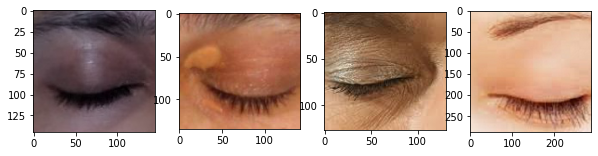

In [3]:
# step 1: read the image names into a list, sort, and printout the length of the list.
path = loc + 'Closed/'
closed_images = os.listdir(path=path)
closed_images.sort()
print("There are ", len(closed_images), "images with closed eyes.")

# take a look at some images
fig=plt.figure(figsize=(10,5))

for i in range(1, 5):
  ax=plt.subplot(1, 4, i)
  ax.imshow(plt.imread(path + closed_images[i-1]))


As we can see, these images have different sizes. So we will need to resize these images to a unique size for all of them.

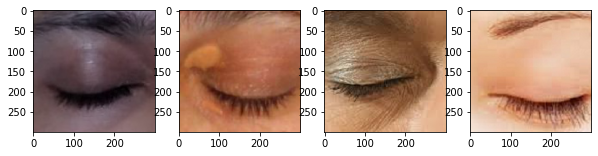

In [4]:
# resize the pictures to 300x300x3 and see again
fig=plt.figure(figsize=(10,5))
for i in range(1, 5):
    ax=plt.subplot(1, 4, i)
    image = tf.keras.utils.load_img(path=path + closed_images[i-1], target_size=(300, 300, 3))
    ax.imshow(image)

In [5]:
# step 2: load each image, preprocess into arrays. 
# resize all images into 300x300x3
x_closed=np.empty((len(closed_images),300,300,3))

image_num = 0
for name in closed_images:
  image = tf.keras.utils.load_img(path=path + name, target_size=(300, 300, 3))
  image_arr = tf.keras.preprocessing.image.img_to_array(image)
  #print(image_arr.shape)
  x_closed[image_num]=image_arr
  image_num += 1

y_closed = np.array([0]*len(closed_images))

print(x_closed.shape, y_closed.shape)

(735, 300, 300, 3) (735,)


### 1.2 Put above code into a function to process and label the other three groups.

In [6]:
def preprocess_images(path, label):

    images = os.listdir(path=path)
    images.sort()
    print("There are ", len(images), "images.")

    # take a look at some images
    fig=plt.figure(figsize=(10,5))

    for i in range(1, 5):
        ax=plt.subplot(1, 4, i)
        ax.imshow(plt.imread(path + images[i-1]))
  
    # step 2: load each image, preprocess into arrays. 
    # resize all images into 300x300x3
    x =np.empty((len(images),300,300,3))

    image_num = 0
    for name in images:
        image = tf.keras.utils.load_img(path=path + name, target_size=(300, 300, 3))
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        x[image_num]=image_arr
        image_num += 1

    y = np.array([label]*len(images))

    print(x.shape, y.shape)

    return x, y


#### 1.2.1 Process and label 'Open' images

There are  726 images.
(726, 300, 300, 3) (726,)
1


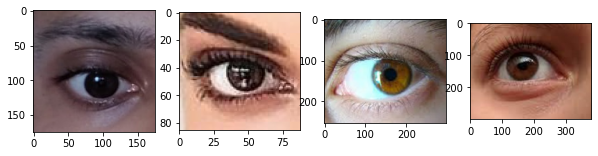

In [7]:
path = loc + 'Open/'
label = 1
x_open, y_open = preprocess_images(path, label)
print(y_open[0])

### 1.2.2 Process and label 'yarn' images

There are  723 images.
(723, 300, 300, 3) (723,)
2


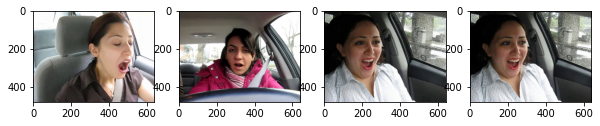

In [8]:
path = loc + 'yawn/'
label = 2
x_yawn, y_yawn = preprocess_images(path, label)
print(y_yawn[0])

### 1.2.3 Process and label 'no-yawn' images

There are  725 images.
(725, 300, 300, 3) (725,)
3


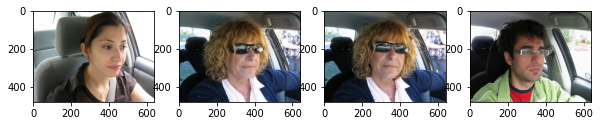

In [9]:
path = loc + 'no_yawn/'
label = 3
x_no_yawn, y_no_yawn = preprocess_images(path, label)
print(y_no_yawn[0])

### 1.3 prepare train and validation data.
   use 10% of each category as validation data.

In [10]:
x_train = np.concatenate([x_closed[:int(x_closed.shape[0]*0.9)], x_open[:int(x_open.shape[0]*0.9)], x_yawn[:int(x_yawn.shape[0]*0.9)], x_no_yawn[:int(x_no_yawn.shape[0]*0.9)]], axis=0)
x_val = np.concatenate([x_closed[int(x_closed.shape[0]*0.9):], x_open[int(x_open.shape[0]*0.9):], x_yawn[int(x_yawn.shape[0]*0.9):], x_no_yawn[int(x_no_yawn.shape[0]*0.9):]], axis=0)
y_train = np.concatenate([y_closed[:int(y_closed.shape[0]*0.9)], y_open[:int(y_open.shape[0]*0.9)], y_yawn[:int(y_yawn.shape[0]*0.9)], y_no_yawn[:int(y_no_yawn.shape[0]*0.9)]], axis=0)
y_val = np.concatenate([y_closed[int(y_closed.shape[0]*0.9):], y_open[int(y_open.shape[0]*0.9):], y_yawn[int(y_yawn.shape[0]*0.9):], y_no_yawn[int(y_no_yawn.shape[0]*0.9):]], axis=0)

In [11]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(2616, 300, 300, 3)
(293, 300, 300, 3)
(2616,)
(293,)


# 2. Establish a network with 2D convolution layer + fully connected neural network.  

In [12]:
from keras.layers import Conv2D, Flatten, MaxPooling2D

In [13]:
# Generate conv2d layers + fully connected neural network with keras

model = Sequential()

#The first conv2d layer
model.add(Conv2D(filters=10, kernel_size=(5,5), strides=(1,1), input_shape = (300,300,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=10, kernel_size=(5,5), strides=(1,1), padding = 'same', activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


# The full connect network 
model.add(Flatten())
# 1 hidden layer
model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(4, activation='softmax', kernel_initializer='he_normal'))

In [14]:
# check the layers of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 10)      760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 10)      2510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 10)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 56250)             0         
                                                                 
 dense (Dense)               (None, 20)                1

In [15]:
# Compile the model
model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = 'adam', 
    metrics = ['accuracy'])

# Train the model
training_1 = model.fit(x_train, y_train, 
                     validation_data = (x_val, y_val),
                      batch_size=10, 
                      epochs = 200,
                     )

Epoch 1/200
262/262 [==============================] - 15s 21ms/step - loss: 35.8951 - accuracy: 0.5604 - val_loss: 1.9886 - val_accuracy: 0.4812
Epoch 2/200
262/262 [==============================] - 5s 18ms/step - loss: 0.6384 - accuracy: 0.6873 - val_loss: 2.3780 - val_accuracy: 0.4676
Epoch 3/200
262/262 [==============================] - 5s 19ms/step - loss: 0.4833 - accuracy: 0.7435 - val_loss: 2.7146 - val_accuracy: 0.4846
Epoch 4/200
262/262 [==============================] - 5s 18ms/step - loss: 0.4324 - accuracy: 0.8031 - val_loss: 2.5140 - val_accuracy: 0.5939
Epoch 5/200
262/262 [==============================] - 5s 18ms/step - loss: 0.4304 - accuracy: 0.8272 - val_loss: 2.3087 - val_accuracy: 0.5597
Epoch 6/200
262/262 [==============================] - 5s 18ms/step - loss: 0.3794 - accuracy: 0.8291 - val_loss: 2.7315 - val_accuracy: 0.6485
Epoch 7/200
262/262 [==============================] - 5s 18ms/step - loss: 0.3656 - accuracy: 0.8528 - val_loss: 2.5827 - val_accurac

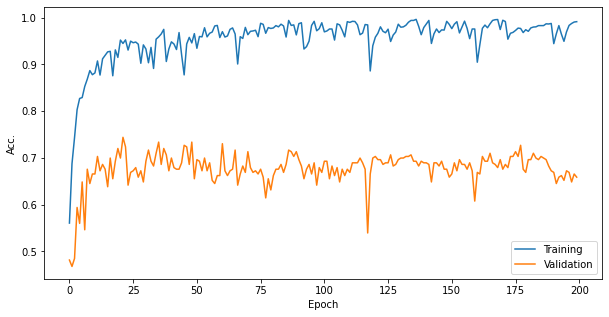

In [17]:
# Plot training and validation accuracy 
acc = np.zeros(shape=(2,200), dtype = float)
acc[0] = training_1.history['accuracy']
acc[1] = training_1.history['val_accuracy']


fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.set_xlabel("Epoch")
ax.set_ylabel("Acc.")

ax.plot(acc[0], label = "Training")
ax.plot(acc[1], label = "Validation")

plt.legend()
plt.show()

### Report of phase I
In Phase I of this final project, we have two main tasks. The first task is to pre-process and label all the images and then split them into training and validation datasets. The second task is to build our first simple neural network consisting of 2D convolutional and fully connected layers, and train our data. 

In the first task, we first loaded all the images and looked at the shape of the images, and printed some of them for observation. We found that the images are irregular and had an inconsistent shape, so we first resized all the images to 300x300x3. The reason for choosing this shape is that it is roughly in the middle of all the image shapes. After preprocessing and labeling all the images, we divided 90% of the images in each category into the training dataset, and the remaining 10% are divided into the validation dataset. Thus we end up with a training dataset of 2616 images and a validation dataset of 293 images.

After completing the first task, we built our first neural network which contains two 2D convolutional layers and two fully connected layers. As we can see from the training, the accuracy of the training dataset can reach 90% after 15 epochs, and reach 99% at some epochs. However, the accuracy of validation mostly stayed below 70%, which would never climb up even up to 200 epochs. Therefore, first, we should modify the pre-processing of the images, and also come up with a better model to best fit our data. 
